# Bioinformatics Data Processing - Final assignment
## Overview
The typical metagenomics workflow involves several steps:
- DNA extraction
- Sequencing
- Assembly
- Genome binning
- Taxonomic and functional analysis

The assignment is based on data from two metagenomics assemblers **metaMDBG** and **myolasm** applied to nanopore sequencing data from a hot spring microbial community. The goal is to compare the performance of both assemblers using only the text-based metadata.
The metadata are from three sources:
- Contig FASTA headers
- **CheckM2** - genome completeness and contamination assessment
- **GTDBtk** - taxonomic assignment

The provided data are stored in the folder `results` in three subfolders: `checkm2`, `gtdbtk` and `contig_headers`.

For the analysis I will use Python with Jupyter Notebook and following libraries:
- pandas
- seaborn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## FASTA headers
Each file contains the headers of the assembled contigs. On each line there is a single header.
### metaMDBG
First line of the file: `>ctg0 length=7710 coverage=2.25 circular=no`.

The [program manual](https://github.com/GaetanBenoitDev/metaMDBG) describes the headers:
- ctgID: the name of the contig
- length: the length of the contig in bps
- coverage: an estimated read coverage for the contig
- circular: whether the contig is circular or no

where each value variable is delimited by a space and the values are delimited by equals sign.

In [2]:
meta_contigs = pd.read_csv('results/contig_headers/metamdbg_assembly_headers.txt', sep=' ', header=None,
                           names=['contig_id', 'length', 'coverage', 'circular'])
meta_contigs["contig_id"] = meta_contigs["contig_id"].str.replace(">", "")
meta_contigs["length"] = meta_contigs["length"].apply(lambda x: int(x.split('=')[1]))
meta_contigs["coverage"] = meta_contigs["coverage"].apply(lambda x: float(x.split('=')[1]))
meta_contigs["circular"] = meta_contigs["circular"].apply(lambda x: True if x.split('=')[1] == "yes" else False)
meta_contigs.head()

,contig_id,length,coverage,circular
0,ctg0,7710,2.25,False
1,ctg1,8229,1.96,False
2,ctg2,10850,3.32,False
3,ctg3,9023,4.85,False
4,ctg4,56052,7.90,False


There are 50109 contigs in the metaMDBG assembly.

In [3]:
meta_contigs.nunique()

contig_id    50109
length       22387
coverage      2056
circular         2
dtype: int64

### myolasm
First line of the file: `>u3840050ctg_len-10849_circular-no_depth-2-2-2_duplicated-no mult=1.00`.

The [program manual](https://myloasm-docs.github.io/output/) describes the headers:
- contig_id
- lenght: len-X - the length of the contig in nucleotides
- circularity: circular-X - whether the contig is circular or not
- depth: depth-X1-X2-X3 - the estimated depth of coverage:
    - X1: is the depth while allowing alignments of approximately > 99% true nucleotide similarity
    - X2: is the depth for > 99.75% similarity
    - X3: is the depth for 100% similarity
- duplicity: duplicated-X - whether the contig is duplicated or not
- mult: mult-X - is the estimated fraction of repetitiveness and useful for quality control. If mult is > 1.1, then duplicated is possibly. If > 1.5, then yes. Otherwise, it is no.

The variables are delimited by an underscore the values are delimited by a hyphen.

In [4]:
mylo_contigs = pd.read_csv('results/contig_headers/myloasm_assembly_headers.txt', sep='_', header=None,
                           names=['contig_id', 'length', 'circular', 'coverage', 'duplicity_multiplicity'])
mylo_contigs["contig_id"] = mylo_contigs["contig_id"].str.replace(">", "")
mylo_contigs["length"] = mylo_contigs["length"].apply(lambda x: int(x.split('-')[1]))
mylo_contigs["circular"] = mylo_contigs["circular"].apply(lambda x: True if x.split('-')[1] == "yes" else False)
mylo_contigs["coverage"] = mylo_contigs["coverage"].apply(lambda x: int(x.split('-')[1]))
mylo_contigs["duplicity"] = mylo_contigs["duplicity_multiplicity"].apply(
    lambda x: True if x.split(' ')[0].split("-")[1] == "yes" else False)
mylo_contigs["multiplicity"] = mylo_contigs["duplicity_multiplicity"].apply(
    lambda x: float(x.split(' ')[1].split("=")[1]))
mylo_contigs.drop(columns=['duplicity_multiplicity'], inplace=True)
mylo_contigs.head()

,contig_id,length,circular,coverage,duplicity,multiplicity
0,u3840050ctg,10849,False,2,False,1.0
1,u418451ctg,23116,False,2,False,1.0
2,u911112ctg,78285,False,27,False,1.0
3,u2187011ctg,16454,False,2,False,1.0
4,u3322747ctg,14907,False,1,False,1.0


There are 53010 contigs in the myloasm assembly.

In [5]:
mylo_contigs.nunique()

contig_id       53010
length          27047
circular            2
coverage          312
duplicity           2
multiplicity      113
dtype: int64

The analysis of contig length distributions reveals a systematic difference in assembly contiguity: the metaMDBG assembly exhibits a distribution statistically skewed toward shorter lengths compared to the myolasm assembly. However, apart from this disparity in central tendency (mean/median length), the assemblers yield broadly comparable results across the measured range of contig sizes.

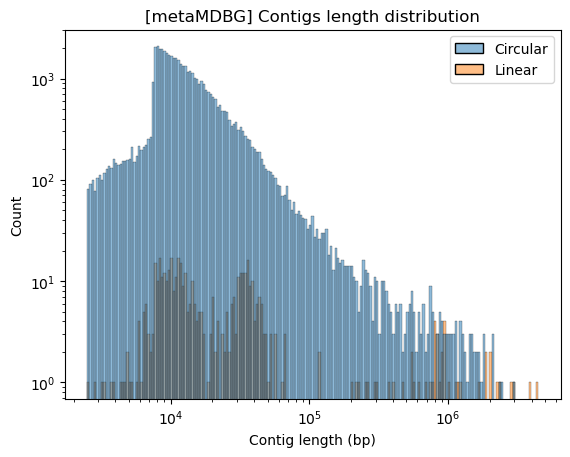

In [6]:
circular_length_df = {"Circular": meta_contigs[~meta_contigs["circular"]]["length"],
                      "Linear": meta_contigs[meta_contigs["circular"]]["length"]}
sns.histplot(circular_length_df, log_scale=True)
plt.title("[metaMDBG] Contigs length distribution")
plt.xlabel("Contig length (bp)")
plt.yscale("log")

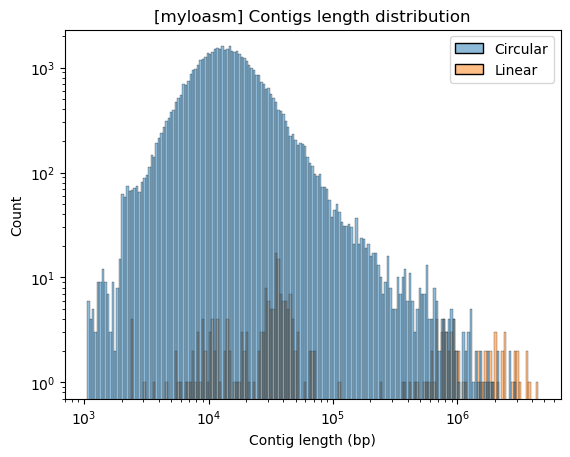

In [7]:
circular_length_df = {"Circular": mylo_contigs[~mylo_contigs["circular"]]["length"],
                      "Linear": mylo_contigs[mylo_contigs["circular"]]["length"]}
sns.histplot(circular_length_df, log_scale=True)
plt.title("[myloasm] Contigs length distribution")
plt.xlabel("Contig length (bp)")
plt.yscale("log")

The scatterplots visualize the relationship between contig length and read coverage. For the metaMDBG assembly, a weak positive correlation is observed between contig length and coverage, strictly confined to the circular contigs. Conversely, the myolasm assembly demonstrates no discernible correlation between these variables in either circular or non-circular contigs.

C:\Users\vilif\AppData\Local\Temp\ipykernel_3520\3676298044.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes.flat[0].set_xticklabels(ax.axes.flat[0].get_xticklabels(), rotation=45, ha='right')


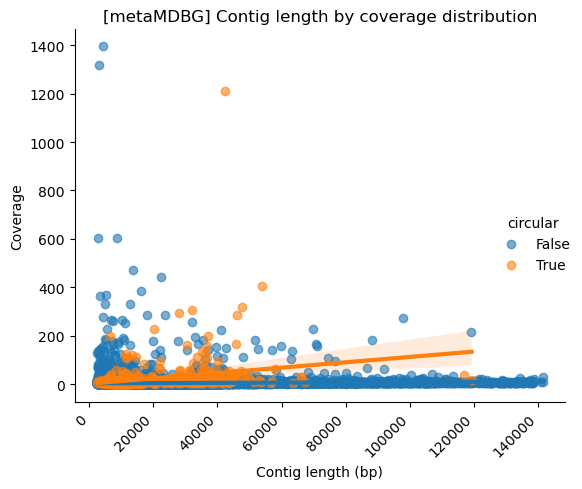

In [8]:
df_filtered = meta_contigs[meta_contigs["length"] < meta_contigs["length"].quantile(.99)]
ax = sns.lmplot(x="length", y="coverage", data=df_filtered, hue="circular", scatter_kws={'alpha': 0.6}, line_kws={"lw": 3})
plt.title("[metaMDBG] Contig length by coverage distribution")
plt.xlabel("Contig length (bp)")
plt.ylabel("Coverage")
ax.axes.flat[0].set_xticklabels(ax.axes.flat[0].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

C:\Users\vilif\AppData\Local\Temp\ipykernel_3520\1371065925.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes.flat[0].set_xticklabels(ax.axes.flat[0].get_xticklabels(), rotation=45, ha='right')


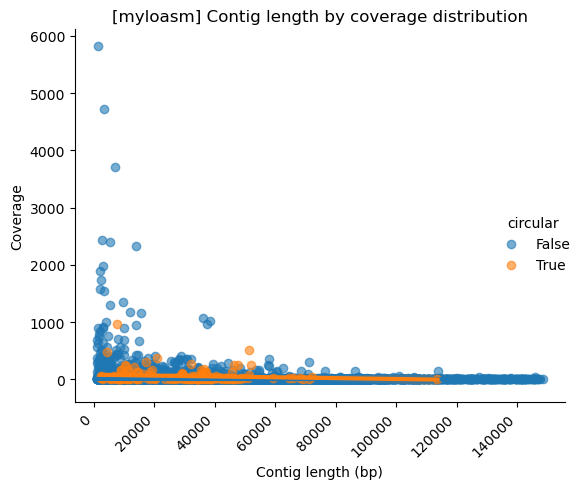

In [9]:
df_filtered = mylo_contigs[mylo_contigs["length"] < mylo_contigs["length"].quantile(.99)]
ax = sns.lmplot(x="length", y="coverage", data=df_filtered, hue="circular", scatter_kws={'alpha': 0.6}, line_kws={"lw": 3})
plt.title("[myloasm] Contig length by coverage distribution")
plt.xlabel("Contig length (bp)")
plt.ylabel("Coverage")
ax.axes.flat[0].set_xticklabels(ax.axes.flat[0].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

When focusing exclusively on long circular contigs (e.g., >500 kb), the normalized length histograms confirm that both assemblers produce contigs with a similar distribution profile. Nevertheless, the myolasm assembler successfully reconstructed nearly double the quantity of these target contigs compared to the metaMDBG assembler.

Count of contigs:
	metaMDBG: 36,
	myolasm: 64


Text(0.5, 0, 'Contig length (bp)')

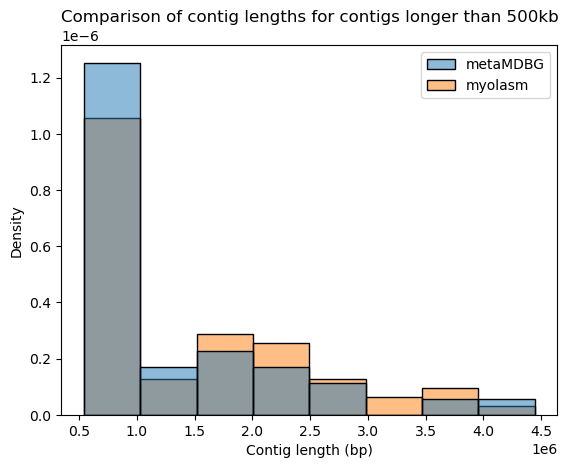

In [10]:
meta_500 = meta_contigs[(meta_contigs["length"] > 500_000) & meta_contigs["circular"]].drop(columns=["circular"])
mylo_500 = mylo_contigs[(mylo_contigs["length"] > 500_000) & mylo_contigs["circular"]].drop(columns=["circular"])
print(f"Count of contigs:\n\tmetaMDBG: {meta_500.shape[0]},\n\tmyolasm: {mylo_500.shape[0]}")
sns.histplot({"metaMDBG": meta_500["length"], "myolasm": mylo_500["length"]}, stat='density', common_norm=False)
plt.title("Comparison of contig lengths for contigs longer than 500kb")
plt.xlabel("Contig length (bp)")

Regarding read coverage for the long circular contigs, the myolasm assembly exhibits a coverage distribution that is distinctly skewed toward lower values. This suggests that the larger number of contigs reconstructed by myolasm (as noted previously) often corresponds to regions with lower sequence depth.

Text(0.5, 0, 'Contig coverage')

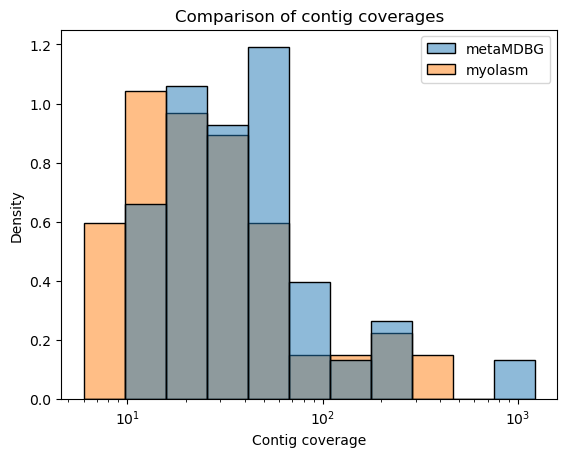

In [11]:
sns.histplot({"metaMDBG": meta_500["coverage"], "myolasm": mylo_500["coverage"]}, stat='density', common_norm=False,
             log_scale=True)
plt.title("Comparison of contig coverages")
plt.xlabel("Contig coverage")

## CheckM2
The next step after the assembly is genome binning. Metagenomics use genome bins as output, they are also known as MAGs (Metagenome-Assembled-Genomes). In the provided data, genome binning was not performed. The analysis is only performed to find (almost) complete MAGs, i.e. circular single contigs. CheckM2 evaluates genome/MAG completeness and contamination using set of markers. The columns of interest are **completeness** and **contaminations**.

In [12]:
meta_m2 = pd.read_csv("results/checkm2/metamdbg/quality_report.tsv", delimiter="\t")[
    ["Name", "Completeness", "Contamination"]]
mylo_m2 = pd.read_csv("results/checkm2/myloasm/quality_report.tsv", delimiter="\t")[
    ["Name", "Completeness", "Contamination"]]
display(meta_m2.head())
display(mylo_m2.head())
print(f"Number of MAGs by assembler:\n\tmetaMDBG: {meta_m2.shape[0]},\n\tmyolasm: {mylo_m2.shape[0]}")

,Name,Completeness,Contamination
0,ctg10973,100.00,5.31
1,ctg11110,95.23,0.08
2,ctg11788,96.85,0.19
3,ctg12262,7.77,0.00
4,ctg12678,96.32,0.27


,Name,Completeness,Contamination
0,u1005671ctg,50.78,0.60
1,u1022233ctg,95.41,0.40
2,u1027066ctg,89.94,2.92
3,u1041087ctg,11.27,0.02
4,u1047122ctg,91.01,0.21


Number of MAGs by assembler:
	metaMDBG: 48,
	myolasm: 103


In [13]:
def quality(row):  # Helper function to define quality of the MAG
    if row["Completeness"] > 90 and row["Contamination"] < 5:
        return "High"
    elif row["Completeness"] > 50 and row["Contamination"] < 10:
        return "Medium"
    else:
        return "Low"


meta_m2["Quality"] = pd.Categorical(meta_m2.apply(quality, axis=1), categories=["Low", "Medium", "High"], ordered=True)
mylo_m2["Quality"] = pd.Categorical(mylo_m2.apply(quality, axis=1), categories=["Low", "Medium", "High"], ordered=True)

Quality
Low       12
Medium     2
High      34
Name: count, dtype: int64


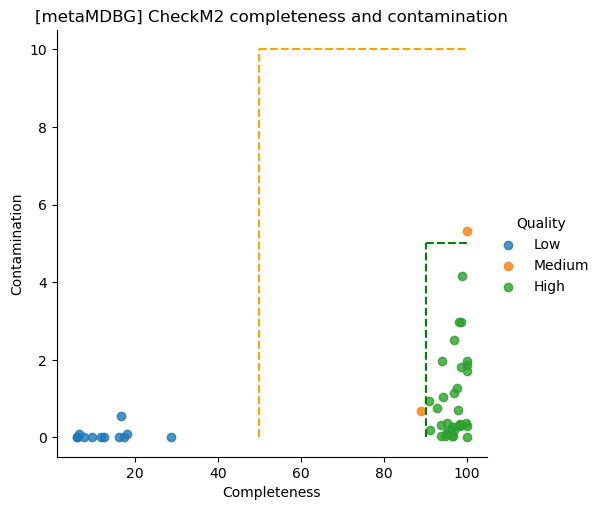

In [14]:
g = sns.lmplot(meta_m2, x="Completeness", y="Contamination", hue="Quality", fit_reg=False)
plt.title("[metaMDBG] CheckM2 completeness and contamination")
g.ax.hlines(5, xmin=90, xmax=100, color="green", linestyle="--")
g.ax.vlines(90, ymin=0, ymax=5, color="green", linestyle="--")
g.ax.hlines(10, xmin=50, xmax=100, color="orange", linestyle="--")
g.ax.vlines(50, ymin=0, ymax=10, color="orange", linestyle="--")
print(meta_m2.Quality.value_counts().sort_index())

Quality
Low       29
Medium    11
High      63
Name: count, dtype: int64


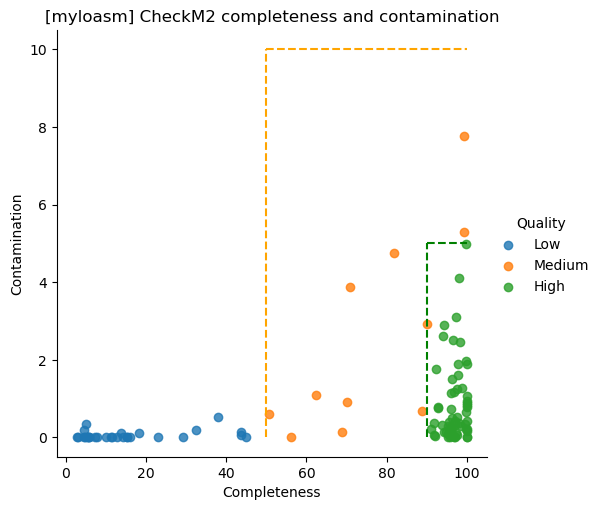

In [15]:
g = sns.lmplot(mylo_m2, x="Completeness", y="Contamination", hue="Quality", fit_reg=False)
plt.title("[myloasm] CheckM2 completeness and contamination")
g.ax.hlines(5, xmin=90, xmax=100, color="green", linestyle="--")
g.ax.vlines(90, ymin=0, ymax=5, color="green", linestyle="--")
g.ax.hlines(10, xmin=50, xmax=100, color="orange", linestyle="--")
g.ax.vlines(50, ymin=0, ymax=10, color="orange", linestyle="--")
print(mylo_m2.Quality.value_counts().sort_index())

Text(0.5, 1.0, 'Comparison by completeness')

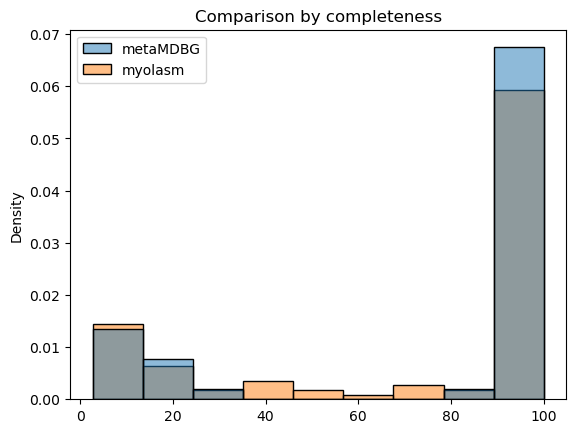

In [16]:
completeness_df = {"metaMDBG": meta_m2["Completeness"], "myolasm": mylo_m2["Completeness"]}
sns.histplot(completeness_df, stat='density', common_norm=False)
plt.title("Comparison by completeness")

Text(0.5, 1.0, 'Comparison by contamination')

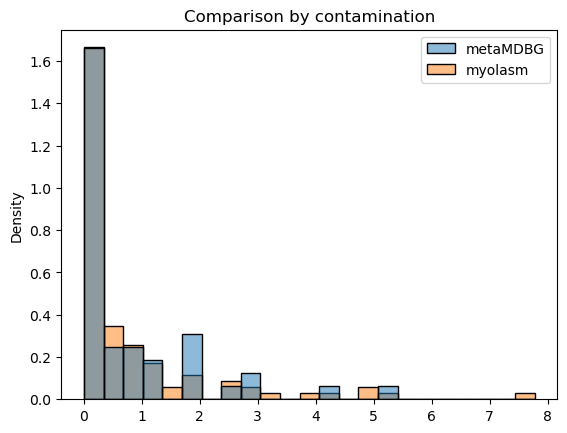

In [17]:
contamination_df = {"metaMDBG": meta_m2["Contamination"], "myolasm": mylo_m2["Contamination"]}
sns.histplot(contamination_df, stat='density', common_norm=False)
plt.title("Comparison by contamination")

Text(0.5, 1.0, 'Comparison by quality')

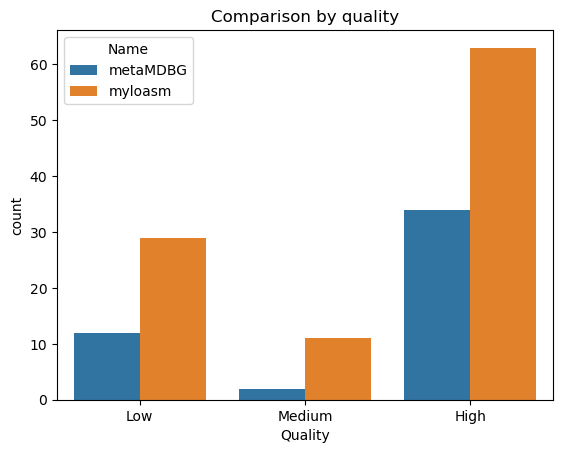

In [18]:
meta_m2_qual = pd.DataFrame(meta_m2.Quality.value_counts()).reset_index()
meta_m2_qual["Name"] = "metaMDBG"
mylo_m2_qual = pd.DataFrame(mylo_m2.Quality.value_counts()).reset_index()
mylo_m2_qual["Name"] = "myloasm"
df_counts = pd.concat([meta_m2_qual, mylo_m2_qual])
sns.barplot(
    data=df_counts,
    x='Quality',
    y='count',
    hue='Name',
)
plt.title("Comparison by quality")

CheckM2 analysis reveals that contigs from the metaMDBG assembly are marginally more complete, though this finding is difficult to interpret definitively given the twofold greater number of contigs produced by the myolasm assembly. In terms of contamination, the myolasm assembly exhibits a slightly lower contamination rate, though the difference between the two assemblers is minimal.

## GTDB-Tk

In [19]:
def prepare_dataset(location, contigs_df):
    df = pd.read_csv(location, delimiter="\t")[["user_genome", "classification"]]
    df = df[~df["classification"].str.contains("Unclassified")]
    df["classification"] = df["classification"].apply(lambda x: x.split(";")[1][3:])
    df = pd.merge(df, contigs_df, left_on=["user_genome"], right_on=["contig_id"], how="inner").drop(columns=["contig_id"])
    df = df[(df.length > 500_000) & (df.circular == True)]
    return df

In [20]:
meta_gtdb_ar53 = prepare_dataset("results/gtdbtk/metamdbg/classify/gtdbtk.ar53.summary.tsv", meta_contigs)
meta_gtdb_bac120 = prepare_dataset("results/gtdbtk/metamdbg/classify/gtdbtk.bac120.summary.tsv", meta_contigs)
mylo_gtdb_ar53 = prepare_dataset("results/gtdbtk/myloasm/classify/gtdbtk.ar53.summary.tsv", mylo_contigs)
mylo_gtdb_bac120 = prepare_dataset("results/gtdbtk/myloasm/classify/gtdbtk.bac120.summary.tsv", mylo_contigs)

Taxonomic analysis demonstrates that both assemblers identified a highly similar number of archaeal MAGs, and the distribution of these identifications across phyla is consistent between the two assemblies. As figure below shows both assemblers found very similar number of Archaea genomes in the same phyla.

Text(0.5, 1.0, 'Comparison of number of large contigs per Archaea phylum between assemblers')

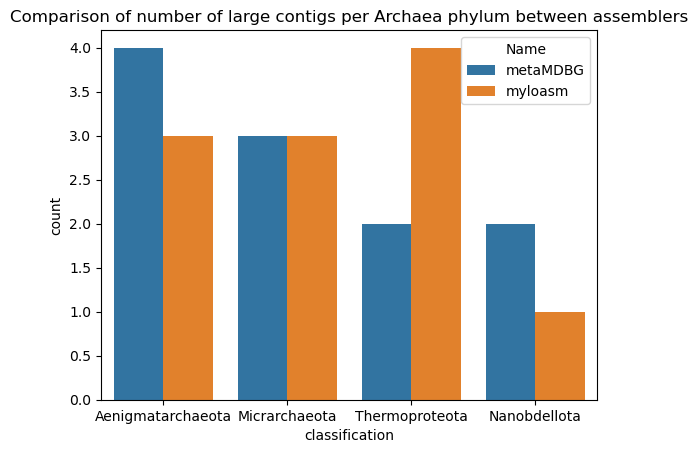

In [21]:
meta_gtdb_ar53_counts = pd.DataFrame(meta_gtdb_ar53.classification.value_counts())
meta_gtdb_ar53_counts["Name"] = "metaMDBG"
mylo_gtdb_ar53_counts = pd.DataFrame(mylo_gtdb_ar53.classification.value_counts())
mylo_gtdb_ar53_counts["Name"] = "myloasm"
df_counts = pd.concat([meta_gtdb_ar53_counts, mylo_gtdb_ar53_counts])
sns.barplot(df_counts, x="classification", y="count", hue="Name")
plt.title("Comparison of number of large contigs per Archaea phylum between assemblers")

In [22]:
pd.concat([meta_gtdb_ar53_counts.drop(columns=["Name"]).rename({"count": "metaMDBG"}, axis=1),
           mylo_gtdb_ar53_counts.drop(columns=["Name"]).rename({"count": "myloasm"}, axis=1)], axis=1).fillna(0).astype(int)

,metaMDBG,myloasm
classification,,
Aenigmatarchaeota,4,3
Micrarchaeota,3,3
Thermoproteota,2,4
Nanobdellota,2,1


The figure below clearly illustrates that the myolasm assembler recovered a substantially greater number of bacterial MAGs compared to the metaMDBG assembler. Furthermore, while the taxonomic diversity was largely similar, the myolasm assembly contained MAGs from two unique phyla, whereas metaMDBG uniquely contributed one distinct phylum.

C:\Users\vilif\AppData\Local\Temp\ipykernel_3520\4155299355.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


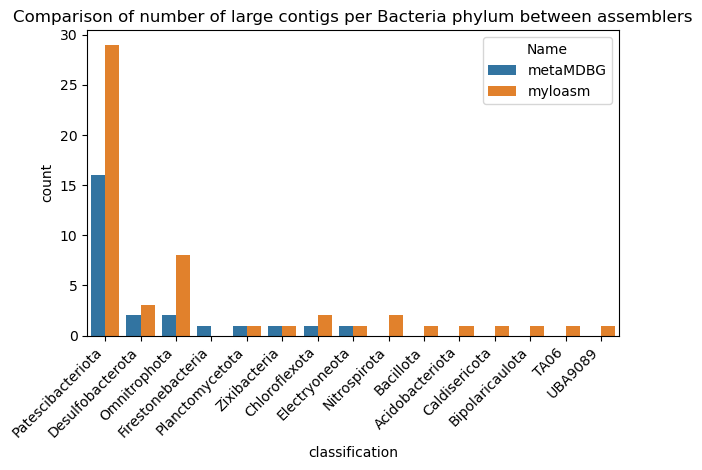

In [23]:
meta_gtdb_bac120_counts = pd.DataFrame(meta_gtdb_bac120.classification.value_counts())
meta_gtdb_bac120_counts["Name"] = "metaMDBG"
mylo_gtdb_bac120_counts = pd.DataFrame(mylo_gtdb_bac120.classification.value_counts())
mylo_gtdb_bac120_counts["Name"] = "myloasm"
df_counts = pd.concat([meta_gtdb_bac120_counts, mylo_gtdb_bac120_counts])
ax = sns.barplot(df_counts, x="classification", y="count", hue="Name")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("Comparison of number of large contigs per Bacteria phylum between assemblers")
plt.tight_layout()

In [24]:
pd.concat([meta_gtdb_bac120_counts.drop(columns=["Name"]).rename({"count": "metaMDBG"}, axis=1),
           mylo_gtdb_bac120_counts.drop(columns=["Name"]).rename({"count": "myloasm"}, axis=1)],
          axis=1).fillna(0).astype(int)

,metaMDBG,myloasm
classification,,
Patescibacteriota,16,29
Desulfobacterota,2,3
Omnitrophota,2,8
Firestonebacteria,1,0
Planctomycetota,1,1
Zixibacteria,1,1
Chloroflexota,1,2
Electryoneota,1,1
Nitrospirota,0,2


### Summary
The myolasm assembly demonstrated superior contiguity and yield, producing a higher total number of contigs and nearly double the quantity of identifiable MAGs. These MAGs maintained a comparable quality distribution to those derived from the metaMDBG assembly.

In terms of taxonomic analysis (GTDB-Tk), both assemblers performed similarly in the Archaea domain. However, the myolasm assembly was significantly more successful in the Bacteria domain, recovering a greater absolute number of MAGs and resolving them into a more diverse set of phyla.